# Forecasting With Tensorflow: Comparing Model Architectures

I made this notebook as practice in preparation for the TensorFlow certification. It is part of a series of notebooks and resources contained in this [github repo](https://github.com/nicholasjhana/tensorflow-certification-study-guide).

This notebook formulates a multi-variable forecasting problem to predict the next 24 hours of energy demand in Spain. In a [previous notebook I used a similar apparoch with a univariate model](https://www.kaggle.com/nicholasjhana/univariate-time-series-forecasting-with-keras) using the same dataset.

This notebook is distinct from the previous implementation because it uses multiple input variables of past energy load, price, hour of the day, day of the week, and month. It does not use the weather inputs. The implementation is also nearly all in Tensorflow, with the exception of data prep and plotting.

Here I compare the forecasting performance of using several different model types. Each model uses the same final two DNN layers with dropout. One of 128 units, and the final layer of 24 (the output horizon). Each of the models unique layers are:
1. A three layer DNN (one layer plus the common bottom two layers)
2. A CNN with two layers of 1D convolutions with max pooling.
3. A LSTM with two LSTM layers.
4. A CNN stacked LSTM with layers from models 2 and 3 feeding into the common DNN layer.
5. A CNN stacked LSTM with a skip connection to the common DNN layer. 

Each model is compared against baseline persistance models consisting of a one day persistence, and a three day average persistence. Added to the baseline error is the Transmission Service Operator's error.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip -o /content/drive/MyDrive/Share/datasets/archive.zip -d /content/

Archive:  /content/drive/MyDrive/Share/datasets/archive.zip
  inflating: /content/energy_dataset.csv  
  inflating: /content/weather_features.csv  


In [4]:
path = "/kaggle/input/energy-consumption-generation-prices-and-weather/energy_dataset.csv"
path = "/content/energy_dataset.csv"

def load_data(col=None, path=path, verbose=False):
    df = pd.read_csv(path)
    if col is not None:
        df = df[col]
    if verbose:
        print(df.head())
    return df

print("Multivariate Sample")
multivar_df = load_data(['time','total load actual', 'price actual'], verbose=True)

Multivariate Sample
                        time  total load actual  price actual
0  2015-01-01 00:00:00+01:00            25385.0         65.41
1  2015-01-01 01:00:00+01:00            24382.0         64.92
2  2015-01-01 02:00:00+01:00            22734.0         64.48
3  2015-01-01 03:00:00+01:00            21286.0         59.32
4  2015-01-01 04:00:00+01:00            20264.0         56.04


In [23]:
_df = pd.read_csv(path)
_df.head(5)

,time,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,...,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
0,2015-01-01 00:00:00+01:00,447.0,329.0,0.0,4844.0,4821.0,162.0,0.0,0.0,0.0,...,196.0,0.0,6378.0,17.0,NaN,6436.0,26118.0,25385.0,50.10,65.41
1,2015-01-01 01:00:00+01:00,449.0,328.0,0.0,5196.0,4755.0,158.0,0.0,0.0,0.0,...,195.0,0.0,5890.0,16.0,NaN,5856.0,24934.0,24382.0,48.10,64.92
2,2015-01-01 02:00:00+01:00,448.0,323.0,0.0,4857.0,4581.0,157.0,0.0,0.0,0.0,...,196.0,0.0,5461.0,8.0,NaN,5454.0,23515.0,22734.0,47.33,64.48
3,2015-01-01 03:00:00+01:00,438.0,254.0,0.0,4314.0,4131.0,160.0,0.0,0.0,0.0,...,191.0,0.0,5238.0,2.0,NaN,5151.0,22642.0,21286.0,42.27,59.32
4,2015-01-01 04:00:00+01:00,428.0,187.0,0.0,4130.0,3840.0,156.0,0.0,0.0,0.0,...,189.0,0.0,4935.0,9.0,NaN,4861.0,21785.0,20264.0,38.41,56.04


# Baseline Error Performance

In order to compare model perofrmance we need an estimate of bayes limit for the problem. In this case we do not have a human error reference. So we use the the lowest of the following:
- ENTSOE recorded forecast. This is the collection of models used by the relevant energy authority.
- Persistance 1 Day. Using the observed values from the previous days as the prediction of the next day.
- Persistance 3 day mean. Using the observations from the previous 3 days as the prediction of the next day.

By establishing a baseline error we have a refernce to compare our training and validation set performance. This guides us to understand where and how a model is performance. For example, if our bayes error is MAE 5% and our model training and validation perform at MAE 6% and 9% respectively then the relevant obserevation is that our model performs with high variance with respect to the baseline. The contrary is true if we consider baseline, train, and validation MAEs of 5%, 8%, and 8.5% respectively. In the latter case we should work on the bias of the training set before considering the validation performance (low variance).

In [5]:
df = load_data(col=["total load forecast","total load actual"])

#fill nans with linear interpolation because this is how we will fill when using the data in the models.
df_filled = df.interpolate("linear")
mm = MinMaxScaler()
df_scaled = mm.fit_transform(df_filled)

df_prep = pd.DataFrame(df_scaled, columns=df.columns)
y_true = df_prep["total load actual"]
y_pred_forecast = df_prep["total load forecast"]

### persistence 1 day
#shift series by 24 hours
# realign y_true to have the same length and time samples
y_preds_persistance_1_day = y_true.shift(24).dropna()
persistence_1_day_mae = tf.keras.losses.MAE(y_true[y_preds_persistance_1_day.index], y_preds_persistance_1_day).numpy()
persistence_1_day_mape = tf.keras.losses.MAPE(np.maximum(y_true[y_preds_persistance_1_day.index], 1e-5), np.maximum(y_preds_persistance_1_day, 1e-5)).numpy()


### persistence 3 day average
#shift by 1, 2, 3 days. Realign to have same lengths. Average days and calcualte MAE.

shift_dfs = list()
for i in range(1, 4):
    shift_dfs.append(pd.Series(y_true.shift(24 * i), name=f"d{i}"))

y_persistance_3d = pd.concat(shift_dfs, axis=1).dropna()
y_persistance_3d["avg"] = (y_persistance_3d["d1"] + y_persistance_3d["d2"] + y_persistance_3d["d3"])/3
d3_idx = y_persistance_3d.index
persistence_3day_avg_mae = tf.keras.losses.MAE(y_true[d3_idx], y_persistance_3d['avg']).numpy()
persistence_3day_avg_mape = tf.keras.losses.MAPE(np.maximum(y_true[d3_idx], 1e-5), np.maximum(y_persistance_3d['avg'], 1e-5)).numpy()


ref_error = pd.DataFrame({
    "Method": ["TSO Forecast", "Persistence 1 Day", "Persitence 3 Day Avg"],
    "MAE": [tf.keras.losses.MAE(y_true, y_pred_forecast).numpy(),
            persistence_1_day_mae,
            persistence_3day_avg_mae],
    "MAPE":[tf.keras.losses.MAPE(np.maximum(y_true, 1e-5), np.maximum(y_pred_forecast, 1e-5)).numpy(),
            persistence_1_day_mape,
            persistence_3day_avg_mape]}, 
    index=[i for i in range(3)])

print("\nSummary of Baseline Errors")
print(ref_error)
print(f"\nAverage error in MW for TSO Forecast {round(df['total load forecast'].mean()*ref_error.iloc[0,1], 2)}")


Summary of Baseline Errors
                 Method       MAE       MAPE
0          TSO Forecast  0.015456   5.472781
1     Persistence 1 Day  0.106903  65.951647
2  Persitence 3 Day Avg  0.115176  84.151898

Average error in MW for TSO Forecast 443.76


We can interpret the MAE errors as the number of megawatts (MW) power deviation on average across the whole dataset. So, the TSO forecast is an average of 443.76 MW of error. MAPE is the average percentage deviation of the forecast per time period. In this case about 5.4% deviation.

# Preparing the Data

We will use tf.datasets to prepare the data. The general strategy is to clean, scale, and split the data before creating the tf.dataset object. These steps can alternatively be done within the tf.dataset itself.

***Cleaning data:*** Fill any missing values with a linear interpolation of the value. Same as done in the persistence dataset.

***Scaling data:*** In all cases the data is min max scaled.

***Features:*** As part of this simple analysis of models two feature sets are prepared. The univariate that contains energy consumption data only. The multivariate that contains energy consumption, price, day of the week, and month of the year.

***Splitting data:*** One year of test data (8769 hourly samples) is put aside to evaluate all the models. The train and validation sets are created with a 65/35 split, resulting in 9207 validation samples - just over one year.

In [6]:
def clean_data(series):
    """Fills missing values. 
    
        Interpolate missing values with a linear approximation.
    """
    series_filled = series.interpolate(method='linear')
        
    return series_filled
        
    
def min_max_scale(dataframe):
    """ Applies MinMax Scaling
    
        Wrapper for sklearn's MinMaxScaler class.
    """
    mm = MinMaxScaler()
    return mm.fit_transform(dataframe)

In [7]:
def make_time_features(series):
    
    #convert series to datetimes
    times = series.apply(lambda x: x.split('+')[0])
    datetimes = pd.DatetimeIndex(times)
    
    hours = datetimes.hour.values
    day = datetimes.dayofweek.values
    months = datetimes.month.values
    
    hour = pd.Series(hours, name='hours')
    dayofw = pd.Series(day, name='dayofw')
    month = pd.Series(months, name='months')
    
    return hour, dayofw, month

hour, day, month = make_time_features(multivar_df.time)
print("Hours")
print(hour.head())
print("Day of Week")
print(day.head())
print("Months")
print(month.head())

Hours
0    0
1    1
2    2
3    3
4    4
Name: hours, dtype: int64
Day of Week
0    3
1    3
2    3
3    3
4    3
Name: dayofw, dtype: int64
Months
0    1
1    1
2    1
3    1
4    1
Name: months, dtype: int64


In [8]:
def split_data(series, train_fraq, test_len=8760):
    """Splits input series into train, val and test.
    
        Default to 1 year of test data.
    """
    #slice the last year of data for testing 1 year has 8760 hours
    test_slice = len(series)-test_len

    test_data = series[test_slice:]
    train_val_data = series[:test_slice]

    #make train and validation from the remaining
    train_size = int(len(train_val_data) * train_fraq)
    
    train_data = train_val_data[:train_size]
    val_data = train_val_data[train_size:]
    
    return train_data, val_data, test_data


multivar_df = clean_data(multivar_df)

#add hour and month features
hours, day, months = make_time_features(multivar_df.time)
multivar_df = pd.concat([multivar_df.drop(['time'], axis=1), hours, day, months], axis=1)

#scale
multivar_df = min_max_scale(multivar_df)
train_multi, val_multi, test_multi = split_data(multivar_df, train_fraq=0.65, test_len=8760)
print("Multivarate Datasets")
print(f"Train Data Shape: {train_multi.shape}")
print(f"Val Data Shape: {val_multi.shape}")
print(f"Test Data Shape: {test_multi.shape}")
print(f"Nulls In Train {np.any(np.isnan(train_multi))}")
print(f"Nulls In Validation {np.any(np.isnan(val_multi))}")
print(f"Nulls In Test {np.any(np.isnan(test_multi))}")

Multivarate Datasets
Train Data Shape: (17097, 5)
Val Data Shape: (9207, 5)
Test Data Shape: (8760, 5)
Nulls In Train False
Nulls In Validation False
Nulls In Test False


# Windowing the Dataset

Use tf.dataset to create a window dataset. This is a vector of past timesteps (n_steps) that is used to predict on a target vector of future steps (n_horizon). The example below shows the output for n_steps = 72 and n_horizon = 24 and the 5 features. So we use the last 3 days (72 hours) to predict the next day (following 24 hours). 

The resulting shape for X will be (batch size, n_steps, features) and Y will be (batch size, n_horizon, features).

In [9]:
def window_dataset(data, n_steps, n_horizon, batch_size, shuffle_buffer, multi_var=False, expand_dims=False):
    """ Create a windowed tensorflow dataset
    
    """

    #create a window with n steps back plus the size of the prediction length
    window = n_steps + n_horizon
    
    #expand dimensions to 3D to fit with LSTM inputs
    #creat the inital tensor dataset
    if expand_dims:
        ds = tf.expand_dims(data, axis=-1)
        ds = tf.data.Dataset.from_tensor_slices(ds)
    else:
        ds = tf.data.Dataset.from_tensor_slices(data)
    
    #create the window function shifting the data by the prediction length
    ds = ds.window(window, shift=n_horizon, drop_remainder=True)
    
    #flatten the dataset and batch into the window size
    ds = ds.flat_map(lambda x : x.batch(window))
    ds = ds.shuffle(shuffle_buffer)    
    
    #create the supervised learning problem x and y and batch
    if multi_var:
        ds = ds.map(lambda x : (x[:-n_horizon], x[-n_horizon:, :1]))
    else:
        ds = ds.map(lambda x : (x[:-n_horizon], x[-n_horizon:]))
    
    ds = ds.batch(batch_size).prefetch(1)
    
    return ds

tf.random.set_seed(42)

n_steps = 72
n_horizon = 24
batch_size = 1
shuffle_buffer = 100


ds = window_dataset(train_multi, n_steps, n_horizon, batch_size, shuffle_buffer, multi_var=True)

print('Example sample shapes')
for idx,(x,y) in enumerate(ds):
    print("x = ", x.numpy().shape)
    print("y = ", y.numpy().shape)
    break

Example sample shapes
x =  (1, 72, 5)
y =  (1, 24, 1)


# Dataset Loading Function

Wrap the above functions into a single function that allows us to build the dataset in the same way each time.

In [10]:
def build_dataset(train_fraq=0.65, 
                  n_steps=24*30, 
                  n_horizon=24, 
                  batch_size=256, 
                  shuffle_buffer=500, 
                  expand_dims=False, 
                  multi_var=False):
    """If multi variate then first column is always the column from which the target is contstructed.
    """
    
    tf.random.set_seed(23)
    
    if multi_var:
        data = load_data(col=['time', 'total load actual', 'price actual'])
        hours, day, months = make_time_features(data.time)
        data = pd.concat([data.drop(['time'], axis=1), hours, day, months], axis=1)
    else:
        data = load_data(col=['total load actual'])
        
    data = clean_data(data)
    
    if multi_var:
        mm = MinMaxScaler()
        data = mm.fit_transform(data)
    
    train_data, val_data, test_data = split_data(data, train_fraq=train_fraq, test_len=8760)
    
    train_ds = window_dataset(train_data, n_steps, n_horizon, batch_size, shuffle_buffer, multi_var=multi_var, expand_dims=expand_dims)
    val_ds = window_dataset(val_data, n_steps, n_horizon, batch_size, shuffle_buffer, multi_var=multi_var, expand_dims=expand_dims)
    test_ds = window_dataset(test_data, n_steps, n_horizon, batch_size, shuffle_buffer, multi_var=multi_var, expand_dims=expand_dims)
    
    
    print(f"Prediction lookback (n_steps): {n_steps}")
    print(f"Prediction horizon (n_horizon): {n_horizon}")
    print(f"Batch Size: {batch_size}")
    print("Datasets:")
    print(train_ds.element_spec)
    
    return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = build_dataset(multi_var=True)

Prediction lookback (n_steps): 720
Prediction horizon (n_horizon): 24
Batch Size: 256
Datasets:
(TensorSpec(shape=(None, None, 5), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None))


# Model Configurations

Define a set of model configurations so that we can call and run each model in the same way. The cgf_model_run dictionary will store the model, its history, and the test datasetset generated.

The default model parameters are:
- n_steps: last 30 days
- n_horizon: next 24 hours
- learning rate: 3e-4

In [11]:
def get_params(multivar=False):
    lr = 3e-4
    n_steps=24*30
    n_horizon=24
    if multivar:
        n_features=5
    else:
        n_features=1
        
    return n_steps, n_horizon, n_features, lr

model_configs = dict()

def cfg_model_run(model, history, test_ds):
    return {"model": model, "history" : history, "test_ds": test_ds}


def run_model(model_name, model_func, model_configs, epochs):
    
    n_steps, n_horizon, n_features, lr = get_params(multivar=True)
    train_ds, val_ds, test_ds = build_dataset(n_steps=n_steps, n_horizon=n_horizon, multi_var=True)

    model = model_func(n_steps, n_horizon, n_features, lr=lr)

    model_hist = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

    model_configs[model_name] = cfg_model_run(model, model_hist, test_ds)
    return test_ds

# Define Each Model

## DNN
A single 128 unit layer plus the common 128 and 24 unit layyers with dropout.

In [12]:
def dnn_model(n_steps, n_horizon, n_features, lr):
    tf.keras.backend.clear_session()
    
    model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(n_steps, n_features)),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(n_horizon)
    ], name='dnn')
    
    loss=tf.keras.losses.Huber()
    optimizer = tf.keras.optimizers.Adam(lr=lr)
    
    model.compile(loss=loss, optimizer='adam', metrics=['mae'])
    
    return model


dnn = dnn_model(*get_params(multivar=True))
dnn.summary()

Model: "dnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 3600)              0         
                                                                 
 dense (Dense)               (None, 128)               460928    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 24)                3096      
                                                                 
Total params: 480,536
Trainable params: 480,536
Non-trainable p

## CNN
Two Conv 1D layers with 64 filters each, and kernel sizes of 6 and 3 respectively. After each Conv1D layer a maxpooling1D layer with size of 2. 

In [13]:
def cnn_model(n_steps, n_horizon, n_features, lr=3e-4):
    
    tf.keras.backend.clear_session()
    
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv1D(64, kernel_size=6, activation='relu', input_shape=(n_steps,n_features)),
        tf.keras.layers.MaxPooling1D(2),
        tf.keras.layers.Conv1D(64, kernel_size=3, activation='relu'),
        tf.keras.layers.MaxPooling1D(2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(128),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(n_horizon)
    ], name="CNN")
    
    loss= tf.keras.losses.Huber()
    optimizer = tf.keras.optimizers.Adam(lr=lr)
    
    model.compile(loss=loss, optimizer='adam', metrics=['mae'])
    
    return model

cnn = cnn_model(*get_params(multivar=True))
cnn.summary()

Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 715, 64)           1984      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 357, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 355, 64)           12352     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 177, 64)          0         
 1D)                                                             
                                                                 
 flatten (Flatten)           (None, 11328)             0         
                                                                 
 dropout (Dropout)           (None, 11328)             0       

## LSTM
Two LSTM layers with 72 and 48 units each.

In [14]:
def lstm_model(n_steps, n_horizon, n_features, lr):
    
    tf.keras.backend.clear_session()
    
    model = tf.keras.models.Sequential([
        tf.keras.layers.LSTM(72, activation='relu', input_shape=(n_steps, n_features), return_sequences=True),
        tf.keras.layers.LSTM(48, activation='relu', return_sequences=False),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(n_horizon)
    ], name='lstm')
    
    loss = tf.keras.losses.Huber()
    optimizer = tf.keras.optimizers.Adam(lr=lr)
    
    model.compile(loss=loss, optimizer='adam', metrics=['mae'])
    
    return model

lstm = lstm_model(*get_params(multivar=True))
lstm.summary()

Model: "lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 720, 72)           22464     
                                                                 
 lstm_1 (LSTM)               (None, 48)                23232     
                                                                 
 flatten (Flatten)           (None, 48)                0         
                                                                 
 dropout (Dropout)           (None, 48)                0         
                                                                 
 dense (Dense)               (None, 128)               6272      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 24)                3096   

## CNN and LSTM Stacked
Using the same layers from the CNN and LSTM model, stack the CNN as input to the pair of LSTMs.

In [15]:
def lstm_cnn_model(n_steps, n_horizon, n_features, lr):
    
    tf.keras.backend.clear_session()
    
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv1D(64, kernel_size=6, activation='relu', input_shape=(n_steps,n_features)),
        tf.keras.layers.MaxPooling1D(2),
        tf.keras.layers.Conv1D(64, kernel_size=3, activation='relu'),
        tf.keras.layers.MaxPooling1D(2),
        tf.keras.layers.LSTM(72, activation='relu', return_sequences=True),
        tf.keras.layers.LSTM(48, activation='relu', return_sequences=False),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(128),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(n_horizon)
    ], name="lstm_cnn")
    
    loss = tf.keras.losses.Huber()
    optimizer = tf.keras.optimizers.Adam(lr=lr)
    
    model.compile(loss=loss, optimizer='adam', metrics=['mae'])
    
    return model

lstm_cnn = lstm_cnn_model(*get_params(multivar=True))
lstm_cnn.summary()

Model: "lstm_cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 715, 64)           1984      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 357, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 355, 64)           12352     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 177, 64)          0         
 1D)                                                             
                                                                 
 lstm (LSTM)                 (None, 177, 72)           39456     
                                                                 
 lstm_1 (LSTM)               (None, 48)                232

## CNN and LSTM with a skip connection
The same CNN and LSTM layers as the previous models this time with a skip connection direct to the common DNN layer.

In [16]:
def lstm_cnn_skip_model(n_steps, n_horizon, n_features, lr):
    
    tf.keras.backend.clear_session()
    
   
    inputs = tf.keras.layers.Input(shape=(n_steps,n_features), name='main')
    
    conv1 = tf.keras.layers.Conv1D(64, kernel_size=6, activation='relu')(inputs)
    max_pool_1 = tf.keras.layers.MaxPooling1D(2)(conv1)
    conv2 = tf.keras.layers.Conv1D(64, kernel_size=3, activation='relu')(max_pool_1)
    max_pool_2 = tf.keras.layers.MaxPooling1D(2)(conv2)
    lstm_1 = tf.keras.layers.LSTM(72, activation='relu', return_sequences=True)(max_pool_2)
    lstm_2 = tf.keras.layers.LSTM(48, activation='relu', return_sequences=False)(lstm_1)
    flatten = tf.keras.layers.Flatten()(lstm_2)
    
    skip_flatten = tf.keras.layers.Flatten()(inputs)

    concat = tf.keras.layers.Concatenate(axis=-1)([flatten, skip_flatten])
    drop_1 = tf.keras.layers.Dropout(0.3)(concat)
    dense_1 = tf.keras.layers.Dense(128, activation='relu')(drop_1)
    drop_2 = tf.keras.layers.Dropout(0.3)(dense_1)
    output = tf.keras.layers.Dense(n_horizon)(drop_2)
    
    model = tf.keras.Model(inputs=inputs, outputs=output, name='lstm_skip')
    
    loss = tf.keras.losses.Huber()
    optimizer = tf.keras.optimizers.Adam(lr=lr)
    
    model.compile(loss=loss, optimizer='adam', metrics=['mae'])
    
    return model

lstm_skip = lstm_cnn_skip_model(*get_params(multivar=True))
lstm_skip.summary()

Model: "lstm_skip"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 main (InputLayer)              [(None, 720, 5)]     0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 715, 64)      1984        ['main[0][0]']                   
                                                                                                  
 max_pooling1d (MaxPooling1D)   (None, 357, 64)      0           ['conv1d[0][0]']                 
                                                                                                  
 conv1d_1 (Conv1D)              (None, 355, 64)      12352       ['max_pooling1d[0][0]']          
                                                                                          

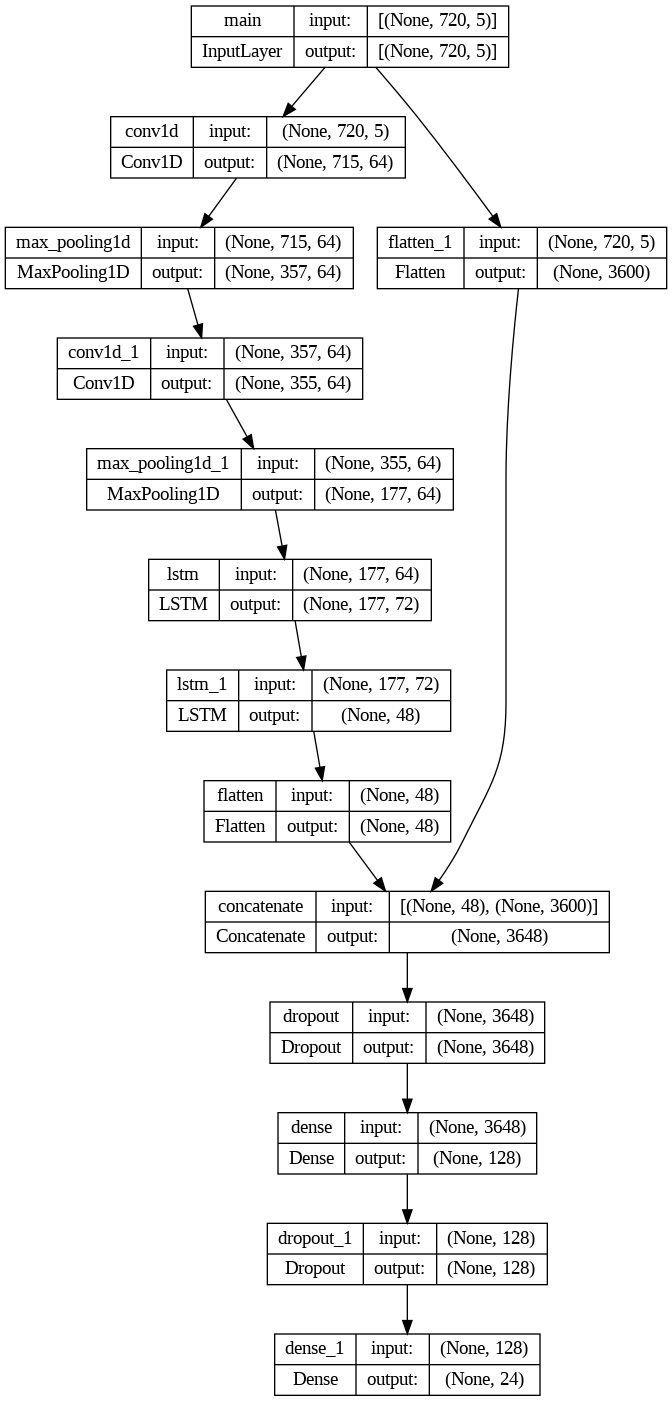

In [17]:
tf.keras.utils.plot_model(lstm_skip, show_shapes=True)

# Train Models
Run each model for 150 epochs.

In [18]:
model_configs=dict()
run_model("dnn", dnn_model, model_configs, epochs=150)
run_model("cnn", cnn_model, model_configs, epochs=150)
run_model("lstm", lstm_model, model_configs, epochs=150)
run_model("lstm_cnn", lstm_cnn_model, model_configs, epochs=150)
run_model("lstm_skip", lstm_cnn_skip_model, model_configs, epochs=150)

Prediction lookback (n_steps): 720
Prediction horizon (n_horizon): 24
Batch Size: 256
Datasets:
(TensorSpec(shape=(None, None, 5), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None))
Epoch 1/150
3/3 [==============================] - 3s 751ms/step - loss: 0.3473 - mae: 0.7004 - val_loss: 0.1171 - val_mae: 0.4037
Epoch 2/150
3/3 [==============================] - 1s 356ms/step - loss: 0.1335 - mae: 0.4213 - val_loss: 0.0942 - val_mae: 0.3624
Epoch 3/150
3/3 [==============================] - 1s 193ms/step - loss: 0.0886 - mae: 0.3485 - val_loss: 0.0920 - val_mae: 0.3444
Epoch 4/150
3/3 [==============================] - 1s 186ms/step - loss: 0.0777 - mae: 0.3314 - val_loss: 0.0894 - val_mae: 0.3448
Epoch 5/150
3/3 [==============================] - 1s 347ms/step - loss: 0.0677 - mae: 0.3073 - val_loss: 0.0766 - val_mae: 0.3159
Epoch 6/150
3/3 [==============================] - 1s 346ms/step - loss: 0.0597 - mae: 0.2789 - val_loss: 0.0655 - val_m

Prediction lookback (n_steps): 720
Prediction horizon (n_horizon): 24
Batch Size: 256
Datasets:
(TensorSpec(shape=(None, None, 5), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None))
Epoch 1/150
3/3 [==============================] - 4s 934ms/step - loss: 0.4593 - mae: 0.8246 - val_loss: 0.1448 - val_mae: 0.4338
Epoch 2/150
3/3 [==============================] - 5s 2s/step - loss: 0.1278 - mae: 0.4079 - val_loss: 0.1574 - val_mae: 0.4788
Epoch 3/150
3/3 [==============================] - 4s 1s/step - loss: 0.1229 - mae: 0.3967 - val_loss: 0.1229 - val_mae: 0.4244
Epoch 4/150
3/3 [==============================] - 3s 793ms/step - loss: 0.0747 - mae: 0.3125 - val_loss: 0.0885 - val_mae: 0.3525
Epoch 5/150
3/3 [==============================] - 5s 2s/step - loss: 0.0445 - mae: 0.2445 - val_loss: 0.0632 - val_mae: 0.2888
Epoch 6/150
3/3 [==============================] - 3s 789ms/step - loss: 0.0275 - mae: 0.1875 - val_loss: 0.0466 - val_mae: 0.253

Epoch 1/150
3/3 [==============================] - 17s 4s/step - loss: 0.1173 - mae: 0.4430 - val_loss: 0.1245 - val_mae: 0.4568
Epoch 2/150
3/3 [==============================] - 12s 5s/step - loss: 0.1088 - mae: 0.4238 - val_loss: 0.1153 - val_mae: 0.4349
Epoch 3/150
3/3 [==============================] - 12s 3s/step - loss: 0.0967 - mae: 0.3933 - val_loss: 0.0992 - val_mae: 0.3943
Epoch 4/150
3/3 [==============================] - 14s 5s/step - loss: 0.0770 - mae: 0.3380 - val_loss: 0.0697 - val_mae: 0.3127
Epoch 5/150
3/3 [==============================] - 13s 5s/step - loss: 0.0545 - mae: 0.2667 - val_loss: 0.0465 - val_mae: 0.2545
Epoch 6/150
3/3 [==============================] - 13s 5s/step - loss: 0.0437 - mae: 0.2352 - val_loss: 0.0428 - val_mae: 0.2416
Epoch 7/150
3/3 [==============================] - 12s 4s/step - loss: 0.0330 - mae: 0.2054 - val_loss: 0.0421 - val_mae: 0.2379
Epoch 8/150
3/3 [==============================] - 13s 5s/step - loss: 0.0266 - mae: 0.1849 - val

Epoch 1/150
3/3 [==============================] - 9s 2s/step - loss: 0.1185 - mae: 0.4460 - val_loss: 0.1240 - val_mae: 0.4546
Epoch 2/150
3/3 [==============================] - 5s 2s/step - loss: 0.1071 - mae: 0.4215 - val_loss: 0.1099 - val_mae: 0.4175
Epoch 3/150
3/3 [==============================] - 5s 2s/step - loss: 0.0872 - mae: 0.3714 - val_loss: 0.0802 - val_mae: 0.3343
Epoch 4/150
3/3 [==============================] - 5s 2s/step - loss: 0.0594 - mae: 0.2838 - val_loss: 0.0599 - val_mae: 0.2808
Epoch 5/150
3/3 [==============================] - 7s 2s/step - loss: 0.0423 - mae: 0.2347 - val_loss: 0.0505 - val_mae: 0.2592
Epoch 6/150
3/3 [==============================] - 7s 2s/step - loss: 0.0345 - mae: 0.2126 - val_loss: 0.0446 - val_mae: 0.2431
Epoch 7/150
3/3 [==============================] - 5s 2s/step - loss: 0.0288 - mae: 0.1931 - val_loss: 0.0383 - val_mae: 0.2302
Epoch 8/150
3/3 [==============================] - 7s 3s/step - loss: 0.0233 - mae: 0.1709 - val_loss: 0

Epoch 1/150
3/3 [==============================] - 11s 2s/step - loss: 0.6576 - mae: 1.0541 - val_loss: 0.1870 - val_mae: 0.5062
Epoch 2/150
3/3 [==============================] - 7s 2s/step - loss: 0.1622 - mae: 0.4667 - val_loss: 0.1147 - val_mae: 0.4283
Epoch 3/150
3/3 [==============================] - 7s 2s/step - loss: 0.1048 - mae: 0.4055 - val_loss: 0.1024 - val_mae: 0.3864
Epoch 4/150
3/3 [==============================] - 6s 2s/step - loss: 0.0997 - mae: 0.3778 - val_loss: 0.0983 - val_mae: 0.3656
Epoch 5/150
3/3 [==============================] - 7s 2s/step - loss: 0.1006 - mae: 0.3769 - val_loss: 0.0969 - val_mae: 0.3711
Epoch 6/150
3/3 [==============================] - 5s 2s/step - loss: 0.0951 - mae: 0.3723 - val_loss: 0.1001 - val_mae: 0.3863
Epoch 7/150
3/3 [==============================] - 6s 2s/step - loss: 0.0959 - mae: 0.3790 - val_loss: 0.0941 - val_mae: 0.3669
Epoch 8/150
3/3 [==============================] - 5s 2s/step - loss: 0.0912 - mae: 0.3600 - val_loss: 

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 5), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None))>

# Evaluation of Training/Validation Results

Loss curves across the models are fairly stable. All models show a flat validation curve while training continues to decline. The LSTM appears to begin to become very overfit from about epoch 100 where the validation loss begins to rise. The lstm_skip also has a point around epoch 50 where the val loss stops decreasing. In all cases this is a sign the models are no longer learning against the validation set. Some options to help improve this are to introduce learning rate decline, or train on longer input sequences.

Plots of the MAE show a similar pattern to the loss plots.


Loss Curves


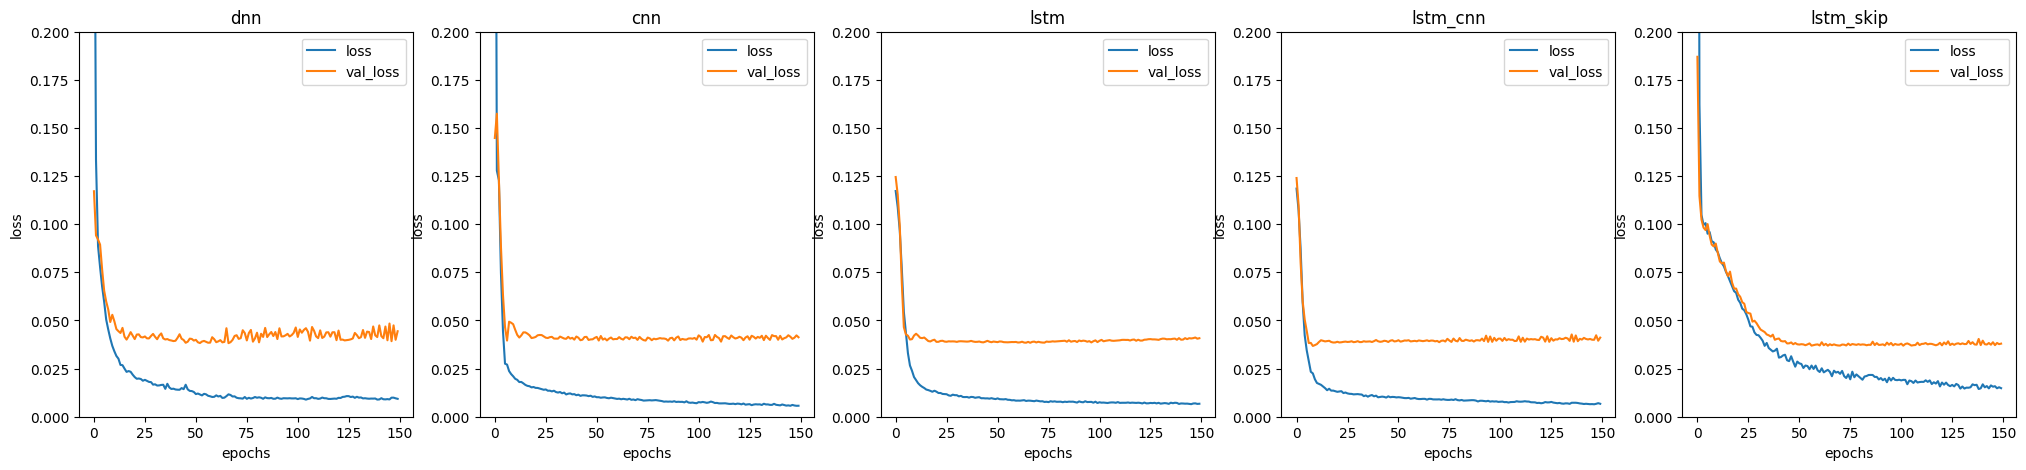

In [19]:
legend = list()

fig, axs = plt.subplots(1, 5, figsize=(25,5))

def plot_graphs(metric, val, ax, upper):
    ax.plot(val['history'].history[metric])
    ax.plot(val['history'].history[f'val_{metric}'])
    ax.set_title(key)
    ax.legend([metric, f"val_{metric}"])
    ax.set_xlabel('epochs')
    ax.set_ylabel(metric)
    ax.set_ylim([0, upper])
    
for (key, val), ax in zip(model_configs.items(), axs.flatten()):
    plot_graphs('loss', val, ax, 0.2)
print("Loss Curves")

MAE Curves


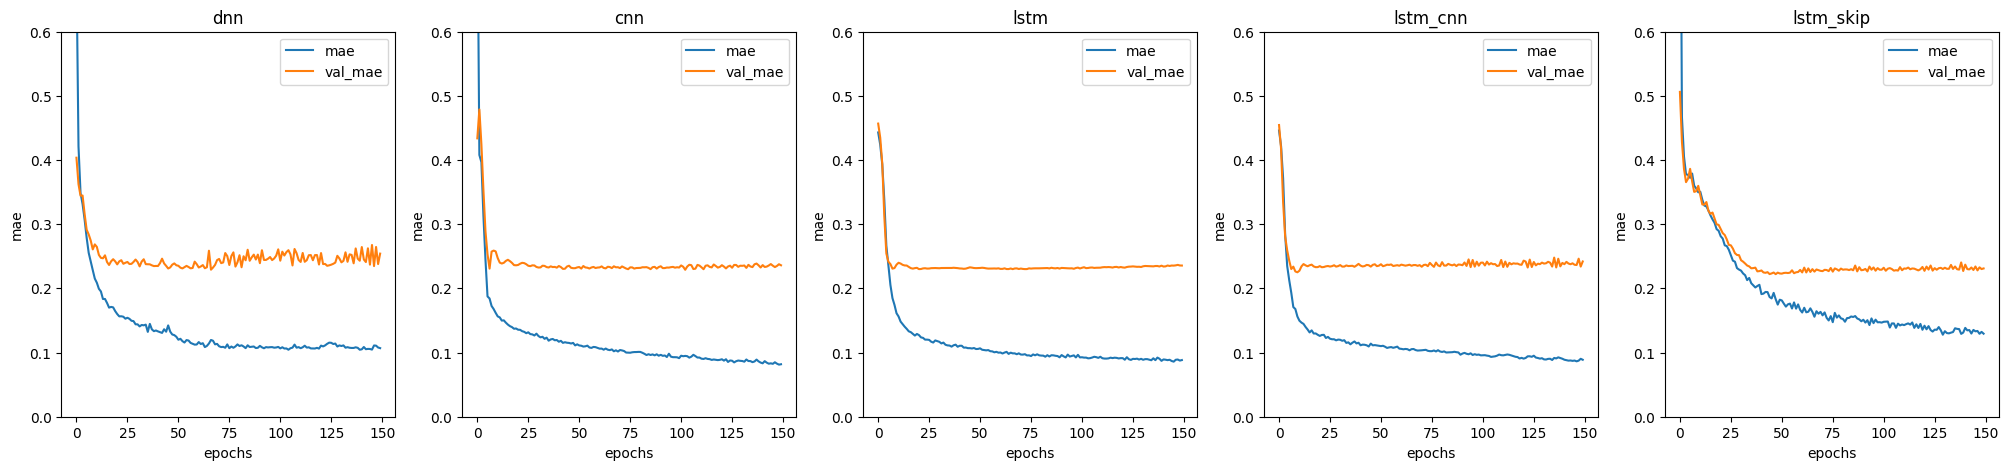

In [20]:
print("MAE Curves")
fig, axs = plt.subplots(1, 5, figsize=(25,5))
for (key, val), ax in zip(model_configs.items(), axs.flatten()):
    plot_graphs('mae', val, ax, 0.6)

# Evaluation of Test Results
The LSTM and the CNN stacked LSTM models clearly outperformed the other four models. Whats surprising is to see how well both a CNN and DNN did on their. LSTM would be expected to perform well because of its ability to learn and remember longer trends in the data.

Comparing to the baseline results the models' performance was poor. The dnn, cnn, lstm, and lstm_cnn models improved against the persistence error (MAE ~ 0.106) but did not improve against the TSO's prediction error (MAE ~0.015, MW error ~443). 

Putting the models' performance in perspective however the results show how with a limited lookback window, and simple features a lstm, and a cnn stacked with an lstm are a good starting choice for architecture.

In [21]:
names = list()
performance = list()

for key, value in model_configs.items():
    names.append(key)
    mae = value['model'].evaluate(value['test_ds'])
    performance.append(mae[1])
    
performance_df = pd.DataFrame(performance, index=names, columns=['mae'])
performance_df['error_mw'] = performance_df['mae'] * df['total load forecast'].mean()
print(performance_df)    

2/2 [==============================] - 1s 175ms/step - loss: 0.0091 - mae: 0.1062
                mae     error_mw
dnn        0.090550  2599.874326
cnn        0.082241  2361.323015
lstm       0.085820  2464.087739
lstm_cnn   0.086489  2483.285103
lstm_skip  0.106152  3047.851675


In [24]:
print("\nSummary of Baseline Errors")
print(ref_error)
print(f"\nAverage error in MW for TSO Forecast {round(df['total load forecast'].mean()*ref_error.iloc[0,1], 2)}")


Summary of Baseline Errors
                 Method       MAE       MAPE
0          TSO Forecast  0.015456   5.472781
1     Persistence 1 Day  0.106903  65.951647
2  Persitence 3 Day Avg  0.115176  84.151898

Average error in MW for TSO Forecast 443.76


# Visualizing Predictions

Plot the actual and predicted 24 hour intervals. Below is the first 14 days of predictions. Interesting to note how the LSTM appears to oscilate over a longer frequency compared with the other models. The CNN also seems to capture the intra day oscillations (within the 24 hour period). Looking at the CNN stacked LSTM we can see how these two characteristics of the model's learning combine.

2/2 [==============================] - 2s 310ms/step


2/2 [==============================] - 1s 171ms/step
First Two Weeks of Predictions


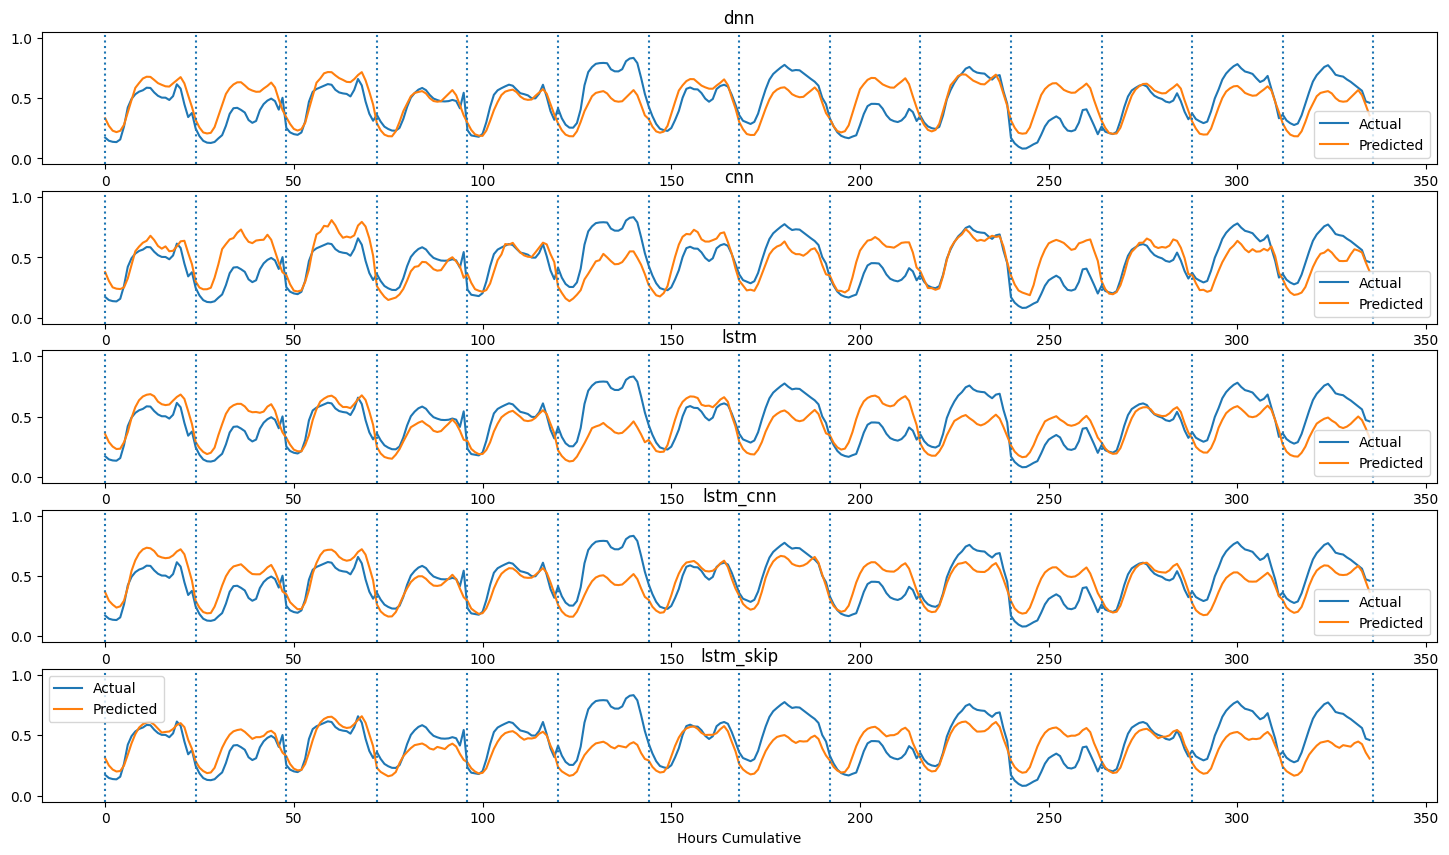

In [22]:
fig, axs = plt.subplots(5, 1, figsize=(18, 10))
days = 14

vline = np.linspace(0, days*24, days+1)

for (key, val), ax in zip(model_configs.items(), axs):

    test = val['test_ds']
    preds = val['model'].predict(test)

    xbatch, ybatch = iter(test).get_next()

    ax.plot(ybatch.numpy()[:days].reshape(-1))
    ax.plot(preds[:days].reshape(-1))
    ax.set_title(key)
    ax.vlines(vline, ymin=0, ymax=1, linestyle='dotted', transform = ax.get_xaxis_transform())
    ax.legend(["Actual", "Predicted"])

plt.xlabel("Hours Cumulative")
print('First Two Weeks of Predictions')

# References
1. [Sequences, Time Series and Prediction, Coursera by Laurence Moroney](https://www.coursera.org/learn/tensorflow-sequences-time-series-and-prediction)